In [ ]:
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import os
import natsort
from torch.utils.data import Dataset, DataLoader

In [ ]:
transforms = transforms.Compose([transforms.Resize((128, 128)),
        #transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [ ]:
#dataset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/Plant_Pathology/train',
#                                           transform=transforms.Compose([transforms.ToTensor()]))

dataset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/Plant_Pathology/train',
                                           transform=transforms)




In [ ]:
print(dataset[2][0].shape)

torch.Size([3, 128, 128])


In [ ]:
trainloader = DataLoader(dataset, batch_size= 20,
                                          shuffle=True, num_workers=3)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
len(dataset)

1821

In [ ]:
class_names=dataset.classes
print(class_names)

['healthy', 'multiple_diseases', 'rust', 'scab']


In [ ]:
resnet = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
import PIL

In [ ]:
len(trainloader)

92

In [ ]:
images, labels = next(iter(trainloader))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


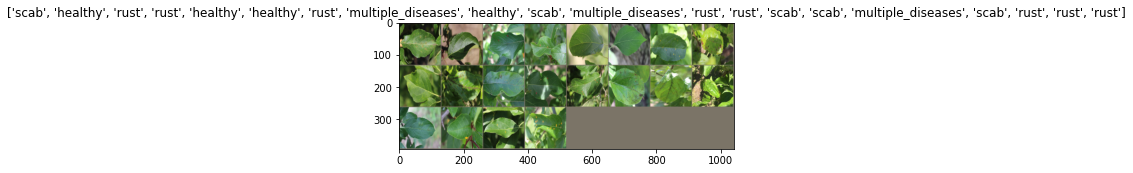

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

out = torchvision.utils.make_grid(images)
imshow(out, title=[class_names[x] for x in labels])

In [ ]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
resnet.fc=nn.Linear(512,4)

In [ ]:
resnet = resnet.cuda()

In [ ]:
resParams = resnet.parameters()
list(resParams)[61].requires_grad

True

In [ ]:
#reset freeze layers
for param in resnet.parameters():
  param.requires_grad = True

In [ ]:
print(resnet.parameters())

<generator object Module.parameters at 0x7f7952099cd0>


In [ ]:
count = 1
for param in resnet.parameters():
  if (count < 55):
    param.requires_grad = False
  count += 1
  print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True


In [ ]:
import torch.optim as optim

In [ ]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(resnet.parameters(), lr = 1e-8)
optimizer = optim.SGD(resnet.parameters(), lr = 0.01, momentum = 0.09)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [ ]:
n_epochs = 20

In [ ]:
print(trainloader)
#batch_idx, (data_, target_) =trainloader

In [ ]:
import torch.nn.functional as F

In [ ]:
train_loss = []
train_acc = []
for epoch in range(n_epochs):
  loss = []
  correct = 0
  total = 0
  print("Epoch:", epoch)
  
  for batch_idx, (data_, target_) in enumerate(trainloader):
    
    data_, target_ = data_.to(device), target_.to(device)
    optimizer.zero_grad()

    outputs = resnet(data_)
    loss_ = criterion(outputs, target_)
    loss_.backward()
    optimizer.step()
    
    # print(outputs.data)

    loss.append(loss_.item())
    # _, pred = F.softmax(outputs.data, dim = 1)
    _, pred = torch.max(outputs, dim = 1)
    # print(pred)
    correct += torch.sum(pred == target_).item()
    total += target_.size(0)
    # print(batch_idx, "| Loss:", loss_.item())
  epochAcc = correct / total * 100
  epochLoss = sum(loss) / len(loss)
  print("Accuracy:", epochAcc, "| Loss:", epochLoss)
  train_acc.append(epochAcc)
  train_loss.append(epochLoss)

print("\n\n--------------------------------------------------\n\n")
for epoch in range(1, n_epochs):
  print("Epoch:", epoch)
  print("Accuracy:", train_acc[epoch] - train_acc[epoch - 1], "| Loss:", train_loss[epoch] - train_loss[epoch - 1])

In [ ]:
def save_model(state, filename="/content/drive/MyDrive/models/resnet18pre.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)



checkpoint = {'state_dict': resnet.state_dict(), 'optimizer' : optimizer.state_dict(),'epochs':20}
save_model(checkpoint)

=> Saving checkpoint


In [ ]:
def load_model(filename="/content/drive/MyDrive/models/resnet18pre.pth.tar"):
    print("=> Loading checkpoint")
    return torch.load(filename)

resnet.load_state_dict(load_model()['state_dict'])
print(resnet)

=> Loading checkpoint
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu):

In [ ]:
for p in resnet.parameters():
  print(p)

In [ ]:
from PIL import Image
import cv2

In [ ]:
class CustomDatasetClass(Dataset):
  def __init__(self,dir,transform):
    self.dir=dir
    self.transforms=transform
    images=os.listdir(dir)
    self.total = natsort.natsorted(images)

  def __len__(self):
    return len(self.total)

  def __getitem__(self, idx):
    img_loc = os.path.join(self.dir, self.total[idx])
    image = Image.open(img_loc).convert("RGB")
    # image = cv2.imread(img_loc, cv2.IMREAD_COLOR)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    tensor_image = self.transforms(image)
    return tensor_image

In [ ]:
testDataset = CustomDatasetClass("/content/drive/MyDrive/plant pathology dataset/plant data/images/test", transform=transforms)
testLoader = DataLoader(testDataset, batch_size=1, shuffle=False, num_workers=2, drop_last=False)